In [ ]:
# Use ResNet50 (headless and pre-trained on Image) to recognize data from Fruits dataset
# On the top of VGG16 we stack Dense layer with outputs corresponding to dataset classes

from __future__ import print_function, division
from builtins import range, input

import tensorflow as tf
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.resnet import ResNet50, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

from glob import glob
import itertools

In [ ]:
# turn on acceleration
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


2022-07-27 18:24:35.485483: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-27 18:24:35.627800: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-27 18:24:35.628962: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Constants

In [ ]:
input_path = '/kaggle/input/fruits/fruits-360_dataset/fruits-360'
train_path = '/kaggle/input/fruits/fruits-360_dataset/fruits-360/Training'
valid_path = '/kaggle/input/fruits/fruits-360_dataset/fruits-360/Test'
os.listdir(input_path)

['papers', 'LICENSE', 'Training', 'readme.md', 'test-multiple_fruits', 'Test']

In [ ]:
IMAGE_SIZE = [100, 100]
epochs = 5
batch_size = 32

## Data & Model

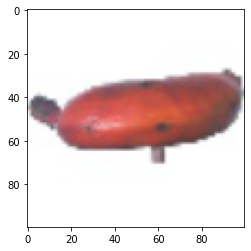

In [ ]:
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')
folders = glob(train_path + '/*')
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

In [ ]:
# prepare resnet
res = ResNet50(input_shape=IMAGE_SIZE+[3], weights='imagenet', include_top=False)
    
# freeze layers trainability
for layer in res.layers:
    layer.trainable = False

# add top layer(s)
x = Flatten()(res.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [ ]:
model = Model(inputs=res.input, outputs=prediction)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 106, 106, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 50, 50, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 50, 50, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
model.compile(
             loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy']
             )

In [ ]:
train_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

val_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [ ]:
test_gen = val_gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k,v in test_gen.class_indices.items():
    labels[v]=k

Found 22688 images belonging to 131 classes.
{'Apple Braeburn': 0, 'Apple Crimson Snow': 1, 'Apple Golden 1': 2, 'Apple Golden 2': 3, 'Apple Golden 3': 4, 'Apple Granny Smith': 5, 'Apple Pink Lady': 6, 'Apple Red 1': 7, 'Apple Red 2': 8, 'Apple Red 3': 9, 'Apple Red Delicious': 10, 'Apple Red Yellow 1': 11, 'Apple Red Yellow 2': 12, 'Apricot': 13, 'Avocado': 14, 'Avocado ripe': 15, 'Banana': 16, 'Banana Lady Finger': 17, 'Banana Red': 18, 'Beetroot': 19, 'Blueberry': 20, 'Cactus fruit': 21, 'Cantaloupe 1': 22, 'Cantaloupe 2': 23, 'Carambula': 24, 'Cauliflower': 25, 'Cherry 1': 26, 'Cherry 2': 27, 'Cherry Rainier': 28, 'Cherry Wax Black': 29, 'Cherry Wax Red': 30, 'Cherry Wax Yellow': 31, 'Chestnut': 32, 'Clementine': 33, 'Cocos': 34, 'Corn': 35, 'Corn Husk': 36, 'Cucumber Ripe': 37, 'Cucumber Ripe 2': 38, 'Dates': 39, 'Eggplant': 40, 'Fig': 41, 'Ginger Root': 42, 'Granadilla': 43, 'Grape Blue': 44, 'Grape Pink': 45, 'Grape White': 46, 'Grape White 2': 47, 'Grape White 3': 48, 'Grape Wh

min:  -78.68 max:  151.061


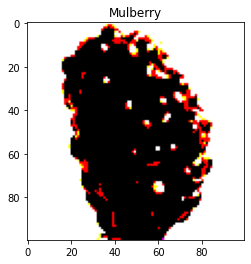

In [ ]:
for x, y in test_gen:
    print("min: ", x[0].min(), "max: ", x[0].max())  # strange colors bc BGR instead of RGB
    plt.title(labels[np.argmax(y[0])])
    plt.imshow(x[0])
    plt.show()
    break

In [ ]:
train_generator = train_gen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    shuffle=True,
    batch_size=batch_size,
    class_mode='sparse'
)

valid_generator = val_gen.flow_from_directory(
    valid_path,
    target_size=IMAGE_SIZE,
    shuffle=False,
    batch_size=batch_size,
    class_mode='sparse'
)

Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


## Actual fitting and resulting

In [ ]:
r = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=epochs,
    steps_per_epoch=len(image_files) // batch_size,
    validation_steps=len(valid_image_files) // batch_size
)

Epoch 1/5
2115/2115 [==============================] - 342s 160ms/step - loss: 1.4772 - accuracy: 0.9042 - val_loss: 1.5677 - val_accuracy: 0.9426
Epoch 2/5
2115/2115 [==============================] - 335s 159ms/step - loss: 0.7399 - accuracy: 0.9677 - val_loss: 2.0569 - val_accuracy: 0.9462
Epoch 3/5
2115/2115 [==============================] - 332s 157ms/step - loss: 0.5895 - accuracy: 0.9781 - val_loss: 1.4068 - val_accuracy: 0.9636
Epoch 4/5
2115/2115 [==============================] - 331s 157ms/step - loss: 0.4947 - accuracy: 0.9839 - val_loss: 1.2106 - val_accuracy: 0.9709
Epoch 5/5
2115/2115 [==============================] - 332s 157ms/step - loss: 0.4281 - accuracy: 0.9865 - val_loss: 1.4647 - val_accuracy: 0.9714


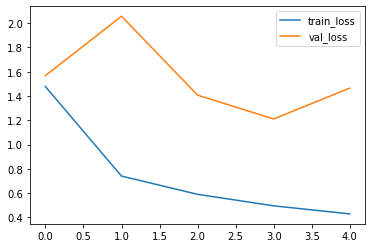

In [ ]:
plt.plot(r.history['loss'], label='train_loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

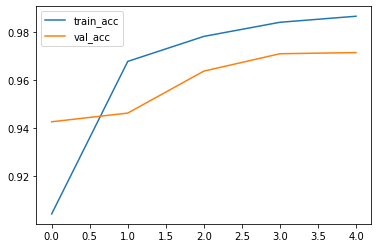

In [ ]:
plt.plot(r.history['accuracy'], label='train_acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [ ]:
def get_confusion_matrix(data_path, N):
    print("Generating confusion matrix", N)
    predictions = []
    targets = []
    i = 0
    n_images = 0
    for x,y in val_gen.flow_from_directory(
                                            data_path, 
                                            target_size=IMAGE_SIZE, 
                                            shuffle=False, 
                                            batch_size=batch_size*2):
        i += 1
        n_images += len(y)
        if i%50 == 0:
            print(f'{n_images} images processed')
        p = model.predict(x)
        p = np.argmax(p, axis=1)
        y = np.argmax(y, axis=1)
        predictions = np.concatenate((predictions, p))
        targets = np.concatenate((targets, y))
        if len(targets) >= N:
            break
    
    cm = confusion_matrix(targets, predictions)
    return cm

cm = get_confusion_matrix(train_path, len(image_files))
print(cm)
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)

[[[492], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]], [[0], [444], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]], [[0], [0], [480], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0]], [[0], [0], [0], [492], [0], [0], [0], [0], [0], [0], [0], [0], [0]], [[0], [0], [0], [3], [464], [14], [0], [0], [0], [0], [0], [0], [0]], [[0], [0], [0], [0], [0], [492], [0], [0], [0], [0], [0], [0], [0]], [[0], [1], [0], [0], [0], [0], [454], [0], [0], [0], [0], [0], [0]], [[0], [0], [0], [0], [0], [0], [0], [487], [0], [0], [0], [0], [0]], [[0], [0], [0], [0], [0], [0], [6], [0], [462], [16], [0], [0], [0]], [[0], [0], [0], [0], [0], [0], [0], [0], [0], [429], [0], [0], [0]], [[0], [0], [0], [0], [0], [0], [0], [1], [0], [0], [488], [0], [0]], [[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [492], [0]], [[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [672]]]


<AxesSubplot:title={'center':'ResNet classifying apple types'}>

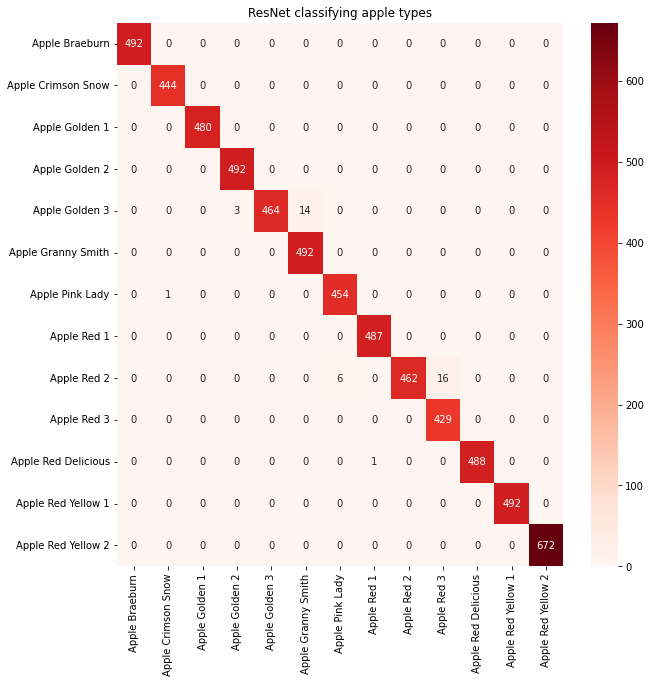

In [ ]:
# check how well it recognizes different apple types
apples_classes_dict = {}
i=0
for label in labels:
    if 'Apple' in label:
        apples_classes_dict[label]=i
    i += 1

apples_cm = []
for i in apples_classes_dict.values():
    row = []
    for j in apples_classes_dict.values():
        row.append([cm[i][j]])
    apples_cm.append(row)
print(apples_cm)

apples_cm = np.array(apples_cm).reshape(len(apples_classes_dict.values()), -1)

plt.figure(figsize=(10,10))
plt.title("ResNet classifying apple types")
sns.heatmap(apples_cm,annot=True,fmt="g",cmap='Reds', 
            xticklabels=apples_classes_dict.keys(), 
            yticklabels=apples_classes_dict.keys())